In [1]:
#!pip install xlrd

In [619]:
from funcoesTermosol import importa , plota
from math import sqrt
import numpy as n

# Definições:

# nn  : Número de nós
# N   : Matriz coordenada de nós
# nm  : Número de elementos
# Inc : Incidência
# nc  : Número de cargas
# F   : Forças
# nr  : Número de restrições
# R   : Matriz de restrições

[nn , N , nm , Inc , nc , F , nr , R] = importa('entrada2.xls')

print(f" > Número de nós = {nn}");
print(f" > Matriz de Coordenasa de nós (x,y) = \n {N}");
print("\n")
print(f" > Número de elementos = {nm}");
print(f" > Matriz de Incidência (no1, no2 , E[Pa] , A[m²])= \n {Inc}");
print("\n")
print(f" > Número de cargas = {nc}");
print(f" > Vetor de Forças = \n {F}");
print("\n")
print(f" > Número de restrições = {nr}");
print(f" > Matriz de Restrições = \n {R}");

 > Número de nós = 7
 > Matriz de Coordenasa de nós (x,y) = 
 [[0.    0.144 0.192 0.288 0.384 0.432 0.576]
 [0.    0.072 0.    0.144 0.    0.072 0.   ]]


 > Número de elementos = 11
 > Matriz de Incidência (no1, no2 , E[Pa] , A[m²])= 
 [[1.0000e+00 2.0000e+00 1.9314e+11 5.2500e-06]
 [2.0000e+00 4.0000e+00 1.9314e+11 5.2500e-06]
 [4.0000e+00 6.0000e+00 1.9314e+11 5.2500e-06]
 [6.0000e+00 7.0000e+00 1.9314e+11 5.2500e-06]
 [2.0000e+00 3.0000e+00 1.9314e+11 5.2500e-06]
 [3.0000e+00 4.0000e+00 1.9314e+11 5.2500e-06]
 [4.0000e+00 5.0000e+00 1.9314e+11 5.2500e-06]
 [5.0000e+00 6.0000e+00 1.9314e+11 5.2500e-06]
 [1.0000e+00 3.0000e+00 1.9314e+11 5.2500e-06]
 [3.0000e+00 5.0000e+00 1.9314e+11 5.2500e-06]
 [5.0000e+00 7.0000e+00 1.9314e+11 5.2500e-06]]


 > Número de cargas = 6
 > Vetor de Forças = 
 [[    0.]
 [    0.]
 [-1300.]
 [-1500.]
 [    0.]
 [    0.]
 [-1300.]
 [-1500.]
 [    0.]
 [    0.]
 [-1300.]
 [-1500.]
 [    0.]
 [    0.]]


 > Número de restrições = 3
 > Matriz de Restrições =

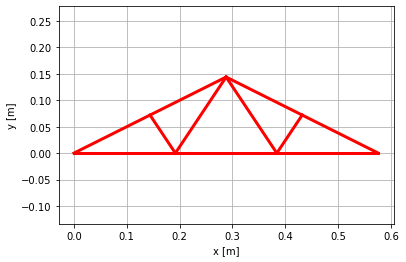

In [620]:
plota(N,Inc)

In [621]:
class Node:
    '''
    Classe representante de um nó.
    
    > id        : Identificador único
    > (x,y)     : Posicionamento no plano 2D
    > gl        : Graus de liberdade do no (em x, em y)
    > restricao : lista de restricao de movimento booleana (em x, em y) 
    > Graus de liberdade dos nós (gl): 
        grau_x = 2*(idx - 1)
        grau_y = 1 + 2*(idx - 1)
    '''
    
    def __init__(self , _id , x , y ):
        
        self.id = _id
        self.x = x
        self.y = y
        
        # Deformações em x e y do no:
        self.dx = 0
        self.dy = 0
        
        # Graus de liberdade:
        self.gx = 2*(_id-1)  
        self.gy = 1+2*(_id-1)
        
    def distance(self , node):
        '''
        Calcula distancia entre dois nós
        '''
        return sqrt((node.x - self.x)**2 + (node.y - self.y)**2)
    
    def show_node(self):
        '''
        Mostra informações relevantes do nó
        '''

        print(f" >> ID node: [{self.id}]")
        print(f" >> Coordenadas [x,y]: ({self.x},{self.y})")
        print(f" >> Graus liberdade [x,y]:  [{self.gx},{self.gy}]")

In [622]:
class Element:
    '''
    Classe representante de um elemento barra simples
    
    node1 - Nó que forma elemento
    node2 - Nó que forma elemento 
    young_module  - Módulo de eleasticidade do elemento
    area - área transversal
    
    '''
    
    def __init__(self, _id , node1 , node2 , young_module , area):
        
        self.id = _id
        self.n1 = node1
        self.n2 = node2
        self.E  = young_module
        self.A  = area
        self.gl = [node1.gx , node1.gy, node2.gx , node2.gy]
        
        self.stiffness = self.create_stiffness_matrix()
        self.deform = None
        self.tension = None
        
        self.seno = None
        self.cosseno = None
         
    def length(self):
        '''
        Tamanho do elemento em metros
        '''
        return self.n1.distance(self.n2)
    
    def k(self):
        '''
        Constante de multiplicação da rigidez
        '''
        
        return (self.E*self.A)/self.length()
        
    def create_stiffness_matrix(self):
        '''
        Calcula matriz de rigidez do elemento
        '''
        
        s = (self.n2.y - self.n1.y)/self.length()
        self.seno = s
        
        c = (self.n2.x - self.n1.x)/self.length()
        self.cosseno = c
        
        matriz = np.array([[c**2 , c*s , -c**2 , -c*s],
                           [c*s , s**2, -c*s , -s**2],
                           [-c**2 , -c*s , c**2 , c*s],
                           [-c*s , -s**2 , c*s ,  s**2]])
        
        self.stiffness = ((self.E*self.A)/self.length())*matriz
        
        return self.stiffness
    
    def solve_deform(self):
        '''
        Calcula deformação específica do elemento no sistema Global
        '''
        
        transform_array = np.array([ -self.cosseno , -self.seno , self.cosseno , self.seno])
        vec_deform = np.array([self.n1.dx, self.n1.dy, self.n2.dx, self.n2.dy])
        
        self.deform = (1/self.length())*np.dot(transform_array, vec_deform)
        
        return self.deform 
    
    def solve_tension(self):
        '''
        Calcula tensão do elemento no sistema Global
        '''
        
        transform_array = np.array([ -self.cosseno , -self.seno , self.cosseno , self.seno]) 
        vec_deform = np.array([self.n1.dx, self.n1.dy, self.n2.dx, self.n2.dy])
        
        self.tension = (self.E/self.length())*np.dot(transform_array, vec_deform)

        return self.tension 
        
    def show_element(self):
        '''
        Mostra informações relevantes do elemento
        '''
        
        print("\n----------------- Element -----------------")
        print(f" >> ID : [{self.id}]")
        print(f" >> Young Module: {self.E}")
        print(f" >> Area: {self.A}")
        print(f" >> Rigidez = {self.stiffness}")
        print(f" >> l = {self.length()}")
        print(f" >> Graus de Liberdade = {self.gl}")
        
        print("\n")
        print("           --  Nodes --              ")
        self.n1.show_node()
        self.n2.show_node()
        print("\n")

In [623]:
class Structure:
    
    def __init__(self, num_elementos , num_nodes , R , N  ,Inc , F):
        
        self.n_ele = num_elementos
        self.n_nos = num_nodes
        self.N = N
        self.Inc = Inc
        self.F = F
        self.restrictions = [int(r[0]) for r in R]
        
        self.F_with_restriction = []
        self.Kg_with_restiction = None
        self.Kg = None
        
        self.nodes_list = []
        self.elements_list = []
        
        self.matriz_coord = np.zeros(shape=(len(N[0]), 2))
        
        self.deforms_list = []
        self.tensions_list = []

    def cria_matriz_coordenadas(self):
        '''
        Ajeita matriz de coordenadas dos nós
        '''
        
        # Ajeita matriz de coordenadas dos nós:

        for i in range(0,len(self.N[0])):
            self.matriz_coord[i][0] = self.N[0][i]
        for  j in range(0, len(self.N[1])):
            self.matriz_coord[j][1] = self.N[1][j]

    def cria_nodes(self):
        '''
        Cria nós
        '''
        
        id_node = 1

        for x,y in self.matriz_coord:
            self.nodes_list.append(Node(id_node , x , y))
            id_node+=1

    def cria_elements(self):
        '''
        Cria elementos
        '''
        
        id_element = 1

        for linha in np.arange(self.n_ele):

            id_node1 = int(self.Inc[linha][0])
            id_node2 = int(self.Inc[linha][1]) 
            
            E = self.Inc[linha][2]
            A = self.Inc[linha][3]

            no1 = Node(id_node1 , self.matriz_coord[id_node1-1][0], self.matriz_coord[id_node1-1][1])
            no2 = Node(id_node2 , self.matriz_coord[id_node2-1][0], self.matriz_coord[id_node2-1][1])

            # Cria elemento:
            elemento = Element(id_element, no1, no2 , E , A)
            # Calcula rigidez
            elemento.create_stiffness_matrix()
            
            self.elements_list.append(elemento)

            #Incrementa numero de elementos
            id_element+=1 
            
                        
    def find_elements_with_respective_gl(self, gl1, gl2):
        '''
        Retorna elementos que possuem os respectivos graus de liberdade gl1 e gl2
        '''
        
        element_gl_list = []
        #print(f"Grau 1 : {gl1} e Grau 2 : {gl2}")
        
        for element in self.elements_list:
            if((gl1 in element.gl) and (gl2 in element.gl)):
                #element.show_element()
                element_gl_list.append(element)
                
        return element_gl_list
        
            
    def solve_Kg(self):
        '''
        Calcula matrix de rigidez global
        '''
        
        self.Kg = np.zeros(shape=(2*self.n_nos, 2*self.n_nos))
        
        for linha in np.arange(2*self.n_nos):
            for coluna in np.arange(2*self.n_nos):
                
                # Lista de elementos que possue esse grau de liberdade
                elem_lits_with_gl = self.find_elements_with_respective_gl(linha,coluna)
                
                for element in elem_lits_with_gl:
                    
                    #Seleciona índices na matriz do elemento que possui o grau de liberdade respectivo 
                    i = element.gl.index(linha)
                    j = element.gl.index(coluna)
                    
                    self.Kg[linha][coluna] += element.stiffness[i][j]              
        
        print(">> Matriz de Rigidez Global:\n ")
        print(self.Kg)
        
    def apply_force_retsriction(self):
        '''
        Aplica retsrições no vetor de força
        '''
        
        self.F_with_restriction = self.F        
        self.F_with_restriction =  np.delete(self.F_with_restriction,self.restrictions , 0)
    
        return self.F_with_restriction
    
    def apply_Kg_restriction(self):
        '''
        Aplica retsrições na matrix de rigidez total
        '''
        
        self.Kg_with_restiction = self.Kg
        
        # Aplica restrições em linhas
        self.Kg_with_restiction =  np.delete(self.Kg_with_restiction,self.restrictions , 0)

        # Aplica restrições em colunas
        self.Kg_with_restiction =  np.delete(self.Kg_with_restiction,self.restrictions , 1)
        
        return self.Kg_with_restiction
    
    def solve_desloc_with_solver(self):
        '''
        Resolve deslocamentos com Numpy
        '''
        
        desloc_vector  = np.linalg.solve(self.Kg_with_restiction , self.F_with_restriction)
        return desloc_vector
    
    def gauss_seidel(self , ite, tolerance):
        '''
        Método numérico de Gauss-Seidel

        > Resolver :
            [A][x] = [b]

        ----------------------------------------

        x1 = (b1 - a12*x2 - a13*x3)/a11
        |
        -----------------
                        |
        x2 = (b2 - a21*x1 - a23*x3)/a22
        |
        --------------------------
                                 |
        x3 = (b3 - a31*x1 - a32*x2)/a33
        '''
    
        x = np.zeros((2, self.F_with_restriction.shape[0]))
        n_iterations = 0

        while(n_iterations < ite):

            # Guarda error relativo:
            error_list = []

            for i in np.arange(0,x.shape[1]): 

                k_aux = np.delete(self.Kg_with_restiction[i,:], i)
                x_aux = np.delete(x[0] , i)

                # Iteração atual
                x[1][i] = ( self.F_with_restriction[i] - np.dot(k_aux , x_aux))/ self.Kg_with_restiction[i][i]

                # Calcula erro e adiciona a lista de erros:
                error_list.append(abs( x[1][i]- x[0][i] )/abs(x[1][i]))   
                
                # Atualiza valor de iteração anterior para ser utilizada no calculo do xi seguinte:
                x[0] = np.copy(x[1])
                
            n_iterations += 1
            error = np.amax(error_list)
            
            if(error <= tolerance):
                print(f"\n-> Convergiu em n = {n_iterations} iterações \n")
                return x[1] , error

        print(f"\n-> Não Convergiu em {n_iterations} iterações !\n")
        print(f"\n-> Error: {error} \n")
        return x[1] , error
        
    def jacobi(self , ite, tolerance):
        '''
        Usando o método numérico Jacobi para encontrar os deslocamentos nodais
        
        > Resolver :
        [A][x] = [b]
        
        -----------------------------------------
        k_aux = [a12 , a13]
        x_aux = [x2 , x3]
        
        x1 = (b1 - a12*x2 - a13*x3)/a11
        
        -----------------------------------------
        k_aux = [a21 , a23]
        x_aux = [x1 , x3]
        
        x2 = (b2 - a21*x1 - a23*x3)/a22
        
        -----------------------------------------
        
        k_aux = [a31 , a32]
        x_aux = [x1 , x2]
        
        x3 = (b3 - a31*x1 - a32*x2)/a33
        
        -----------------------------------------
        
        > Queremos resolver:
        [K]{u} = [F]
        
        - [K]  -> matriz de rigidez global
        - {u}   -> vetor deslocamento
        - [F]  -> vetor global de forças
        
        '''
        
        n_iterations = 0
        
        # Vetor de deslocamentos sem considerar os gl de nodes restritos
        # x[i][j] -> i = 0  (iteração anterior) e  i = 1 (iteração atual)
        #         -> j : deslocamentos
        x = np.zeros((2, self.F_with_restriction.shape[0]))
                
        while(n_iterations < ite):
            # Guarda error relativo:
            error_list = []
            
            # Atualiza valor de iteração anterior:
            x[0] = np.copy(x[1])
            
            for i in np.arange(0,x.shape[1]): 
                
                k_aux = np.delete(self.Kg_with_restiction[i,:], i)
                x_aux = np.delete(x[0] , i)
                
                # Iteração atual
                x[1][i] = ( self.F_with_restriction[i] - np.dot(k_aux , x_aux))/ self.Kg_with_restiction[i][i]
                
                # Calcula erro e adiciona a lista de erros:
                error_list.append(abs( x[1][i]- x[0][i])/abs(x[1][i]))
                                
            n_iterations+=1    
            
            error = np.amax(error_list)
            
            if(error <= tolerance):
                print(f"\n-> Convergiu em n = {n_iterations} iterações \n")
                return x[1] , error
        
        print(f"\n-> Não Convergiu em {n_iterations} iterações !\n")
        print(f"\n-> Error: {error} \n")
        
        return x[1] , error
        
    def calc_deforms(self):
        '''
        Põem deformações de cada elemento em uma lista
        '''
        
        for element in self.elements_list:
            self.deforms_list.append(element.solve_deform())
            
        print(f'\n> Lista de deformações :  {self.deforms_list}\n')
            
    def calc_tensions(self):
        '''
        Põem tensões internas de cada elemento em uma lista
        '''
        
        for element in self.elements_list:
            self.tensions_list.append(element.solve_tension())
            
        print(f'\n> Lista de tensões :  {self.tensions_list}\n')

In [624]:
trelica = Structure(nm , nn , R ,  N , Inc , F)
print(f"Numero de nós : {trelica.n_nos}")
print(f"Numero de elementos : {trelica.n_ele}")

# Ajusta estrutura de coordenadas
trelica.cria_matriz_coordenadas()

# Cria elementos e nodes
trelica.cria_nodes()
trelica.cria_elements()

# Calcula Rigidez Global
trelica.solve_Kg()

# Restrições:
print(trelica.restrictions)

# Vetor global de forças com restrições
print(trelica.apply_force_retsriction())

# Kg com restrição
print(f"\n>\n {trelica.apply_Kg_restriction()}")

# Calcula deslocamentos com numpy:
trelica.solve_desloc_with_solver()

Numero de nós : 7
Numero de elementos : 11
>> Matriz de Rigidez Global:
 
[[ 1.03197038e+07  2.51926599e+06 -5.03853197e+06 -2.51926599e+06
  -5.28117188e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.51926599e+06  1.25963299e+06 -2.51926599e+06 -1.25963299e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.03853197e+06 -2.51926599e+06  1.36825619e+07 -3.69714935e+05
  -3.60549794e+06  5.40824691e+06 -5.03853197e+06 -2.51926599e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.51926599e+06 -1.25963299e+06 -3.69714935e+05  1.06316363e+07
   5.40824691e+06 -8.11237036e+06 -2.51926599e+06 -1.25963299e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000

array([[ 0.00100474],
       [-0.00431173],
       [ 0.00035977],
       [-0.00466313],
       [ 0.00025974],
       [-0.00443928],
       [ 0.00055859],
       [-0.00463759],
       [-0.00032427],
       [-0.00424778],
       [ 0.00116451]])

In [625]:
# Aplicando Gauss-Seide
desloc_vector_reduced , error = trelica.gauss_seidel(ite = 1000 , tolerance = 1e-6)


-> Convergiu em n = 448 iterações 



In [627]:
# Ajeita vetor deslocamento para considerar todos os graus de liberdade:
desloc_vector = np.zeros((2*nn, 1))
counter = 0

for i in np.arange(2*nn):
    
    if i in trelica.restrictions:
        desloc_vector[i] = 0
    else:
        desloc_vector[i] =  desloc_vector_reduced[counter]
        counter+=1
    
desloc_vector

array([[ 0.        ],
       [ 0.        ],
       [ 0.00100472],
       [-0.00431169],
       [ 0.00035976],
       [-0.00466309],
       [ 0.00025973],
       [-0.00443924],
       [ 0.00055858],
       [-0.00463755],
       [-0.00032428],
       [-0.00424775],
       [ 0.0011645 ],
       [ 0.        ]])

In [628]:
for i in range(0, trelica.n_nos):
    trelica.elements_list[i].n1.dx = desloc_vector[trelica.elements_list[i].gl[0]][0]
    trelica.elements_list[i].n1.dy = desloc_vector[trelica.elements_list[i].gl[1]][0]
    trelica.elements_list[i].n2.dx = desloc_vector[trelica.elements_list[i].gl[2]][0]
    trelica.elements_list[i].n2.dy = desloc_vector[trelica.elements_list[i].gl[3]][0]  

In [629]:
# Calcula deformações e tensões de cada elemento:
trelica.calc_deforms()
trelica.calc_tensions()


> Lista de deformações :  [-0.006395129708218694, -0.004493122570412796, -0.003776421171026129, -0.0035283300138792446, -0.0007556004057329427, 0.0007555960169104979, 0.0019112468563298722, 0.0, 0.0, 0.0, 0.0]


> Lista de tensões :  [-1235155351.8453586, -867801693.2495275, -729377984.9719864, -681461658.8806374, -145936662.36326054, 145935814.70609358, 369138217.8315515, 0.0, 0.0, 0.0, 0.0]



In [630]:
# Calculo das reações de apoio:

reaction_forces = np.matmul(trelica.Kg, desloc_vector)

#Pegando apenas as forças que estão sofrendo restrição:
reaction_forces = np.take(reaction_forces, trelica.restrictions)
print("\n> Reações de apoio: \n")
print(reaction_forces)


> Reações de apoio: 



array([3900.01179916, 2899.98589597, 1599.98432298])

In [631]:
# Calculo das forças internas:

element_area = np.array([ element.A for element in trelica.elements_list])
print(element_area)

internal_force = trelica.tensions_list*element_area
print("\n> Forças Internas: \n")
print(internal_force)

[5.25e-06 5.25e-06 5.25e-06 5.25e-06 5.25e-06 5.25e-06 5.25e-06 5.25e-06
 5.25e-06 5.25e-06 5.25e-06]

> Forças Internas: 



array([-6484.56559719, -4555.95888956, -3829.2344211 , -3577.67370912,
        -766.16747741,   766.16302721,  1937.97564362,     0.        ,
           0.        ,     0.        ,     0.        ])